In [36]:
from google.colab import files
import io
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from keras import layers
from keras import models
from keras.applications import vgg16
import pandas as pd
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications import inception_v3
import tensorflow as tf
import glob
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import os

In [2]:
#read train csv
uploaded_files = files.upload()

Saving train.csv to train.csv


In [3]:
train_csv = pd.read_csv(io.BytesIO(uploaded_files['train.csv']))

In [4]:
train_csv =train_csv.sort_values(by = 'image_ID',ascending = False)

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%ls


drive/  sample_data/  train.csv


In [6]:
%cd drive/MyDrive

/content/drive/MyDrive


In [7]:
%ls

 appsheet/
'Colab Notebooks'/
 CV_2021-07-23-081110.pdf
 div_2012.csv
'Divorces_in_South_Africa_2012 WORKBOOK.xlsx'
'divorce word 3.docx'
'How to get started with Drive.pdf'
'o(1).pdf'
 second_tuning_model.h5
 some_train/
 test/
 validation/


In [8]:
train_split = train_csv[train_csv['image_ID'].isin(os.listdir('some_train'))]

In [9]:
validation_split = train_csv[train_csv['image_ID'].isin(os.listdir('validation'))]

In [10]:
conv_base = vgg16.VGG16(weights = 'imagenet',include_top=False,input_shape = (150,150,3))

58900480/58889256 [==============================] - 0s 0us/step


In [11]:
base_url = '/content/drive/MyDrive'

In [12]:
datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_split, directory=os.path.join(base_url, 'some_train'),
                        x_col = "image_ID",color_mode='rgb',
                        y_col = "label",class_mode="categorical",
                        target_size=(150,150),batch_size=32)

Found 6000 validated image filenames belonging to 7 classes.


In [14]:
validation_generator = datagen.flow_from_dataframe(dataframe=validation_split, directory=os.path.join(base_url, 'validation'),
                        x_col = "image_ID", color_mode='rgb',
                        y_col = "label",class_mode="categorical",target_size=(150,150),batch_size=32)

Found 2227 validated image filenames belonging to 7 classes.


In [15]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

In [16]:
STEP_SIZE_TRAIN

187

In [17]:
conv_base.trainable = True

In [18]:
set_trainable = False
for i in conv_base.layers:
    if i.name =='block5_c0nv1':
        set_trainable = True
    if set_trainable:
        i.trainable ==True
    else:
        i.trainable = False 

In [19]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(7,activation='softmax'))

In [20]:
model.compile(optimizer=optimizers.Adam(learning_rate = 1e-5),loss='categorical_crossentropy',metrics=['acc'])

In [21]:
callback = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights = True)

In [22]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = STEP_SIZE_TRAIN,
                              epochs = 100,
                              validation_data=validation_generator,
                              validation_steps = STEP_SIZE_VALID,
                              shuffle = True,
                              callbacks = [callback])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100
187/187 [==============================] - 1891s 10s/step - loss: 1.7357 - acc: 0.3425 - val_loss: 1.4995 - val_acc: 0.4746
Epoch 2/100
187/187 [==============================] - 108s 581ms/step - loss: 1.3374 - acc: 0.5602 - val_loss: 1.2485 - val_acc: 0.5888
Epoch 3/100
187/187 [==============================] - 89s 474ms/step - loss: 1.1212 - acc: 0.6384 - val_loss: 1.1110 - val_acc: 0.6427
Epoch 4/100
187/187 [==============================] - 89s 474ms/step - loss: 0.9830 - acc: 0.6893 - val_loss: 1.0070 - val_acc: 0.6726
Epoch 5/100
187/187 [==============================] - 90s 483ms/step - loss: 0.8855 - acc: 0.7311 - val_loss: 0.9394 - val_acc: 0.6984
Epoch 6/100
187/187 [==============================] - 90s 482ms/step - loss: 0.8078 - acc: 0.7560 - val_loss: 0.8891 - val_acc: 0.7129
Epoch 7/100
187/187 [==============================] - 90s 484ms/step - loss: 0.7475 - acc: 0.7745 - val_loss: 0.8417 - val_acc: 0.7296
Epoch 8/100
187/187 [==========================

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [24]:
pochs = range(1,len(acc)+1)

<Figure size 432x288 with 0 Axes>

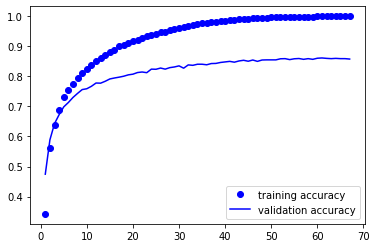

<Figure size 432x288 with 0 Axes>

In [25]:
plt.plot(pochs, acc,'bo',label = 'training accuracy')
plt.plot(pochs, val_acc, 'b', label = 'validation accuracy')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

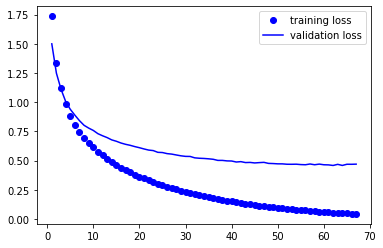

<Figure size 432x288 with 0 Axes>

In [26]:
plt.plot(pochs, loss,'bo',label = 'training loss')
plt.plot(pochs, val_loss, 'b', label = 'validation loss')
plt.legend()
plt.figure()

In [28]:
model.save('fine_tuning_second_model.h5')

In [ ]:
evaluation_m = models.load('fine_tuning_second_model')

In [30]:
label_map = (train_generator.class_indices)

In [31]:
class_names = [(i) for  i in label_map.keys()]

In [32]:
class_names

['Badminton', 'Cricket', 'Karate', 'Soccer', 'Swimming', 'Tennis', 'Wrestling']

In [33]:
test_images = glob.glob(os.path.join(base_url, 'test','*'))

In [34]:
test_images

['/content/drive/MyDrive/test/264c8e9abc.jpg',
 '/content/drive/MyDrive/test/68e8bd825d.jpg',
 '/content/drive/MyDrive/test/3576a9910f.jpg',
 '/content/drive/MyDrive/test/ea8a27fca9.jpg',
 '/content/drive/MyDrive/test/fd9a8ceaf5.jpg',
 '/content/drive/MyDrive/test/c7289dda60.jpg',
 '/content/drive/MyDrive/test/89e5c6004f.jpg',
 '/content/drive/MyDrive/test/b3fccc518a.jpg',
 '/content/drive/MyDrive/test/92b671c30d.jpg',
 '/content/drive/MyDrive/test/8232c1808d.jpg',
 '/content/drive/MyDrive/test/4d1f2b2480.jpg',
 '/content/drive/MyDrive/test/881039e941.jpg',
 '/content/drive/MyDrive/test/63ebf359df.jpg',
 '/content/drive/MyDrive/test/a5de006a2d.jpg',
 '/content/drive/MyDrive/test/dacf01793c.jpg',
 '/content/drive/MyDrive/test/b9e22d65db.jpg',
 '/content/drive/MyDrive/test/3ad51211fa.jpg',
 '/content/drive/MyDrive/test/85d63c490a.jpg',
 '/content/drive/MyDrive/test/002259d705.jpg',
 '/content/drive/MyDrive/test/be33889200.jpg',
 '/content/drive/MyDrive/test/a5d1d612d9.jpg',
 '/content/dr

In [38]:
dt = {'image_id':[], 'prediction_label':[]}
for i in test_images:
    img = image.load_img(i,target_size =(150,150))
    x = image.img_to_array(img)
    x = np.expand_dims(x,axis=0)
    pred=model.predict(x)
    pred=np.argmax(pred,axis=1)
    dt['image_id'].append(i.split('/')[-1])
    dt['prediction_label'].append(pred)

In [40]:
test_predicted = pd.DataFrame.from_dict(dt)

In [41]:
label_map

{'Badminton': 0,
 'Cricket': 1,
 'Karate': 2,
 'Soccer': 3,
 'Swimming': 4,
 'Tennis': 5,
 'Wrestling': 6}

In [42]:
class_names

['Badminton', 'Cricket', 'Karate', 'Soccer', 'Swimming', 'Tennis', 'Wrestling']

In [43]:
test_predicted['prediction_label'] = test_predicted['prediction_label'].replace([[0],[1],[2],[3],[4],[5],[6]], class_names)

In [44]:
test_predicted.to_csv('test_predicted.csv')